**Chapter 1** RNA-Seq 数据处理与分析：比对、质量控制与定量（RNA-Seq Data Processing and Analysis: Alignment, Quality Control, and Quantification）

**Section 1-4** RSEM与Salmon结果对比（Compare RSEM vs Salmon）

本节参考 *STAT 115 2021 Homework 1 Problem 6*

我们完成了 RSEM 和 Salmon 这两种不同的 RNA-Seq 定量计算算法。并且在上一节中，我们对比了两种定量计算速度上的差异，Salmon（3秒）远远地快于RSEM（32秒）。

本节我们对比两种定量计算方法在结果上的差异。我们主要通过对比以下几个指标：effective length (有效长度), normalized read counts (标准化读数), TPM 和 FPKM，来分析两者定量结果的差异。

## 1 数据预处理

现在我们需要关注RSEM和Salmon中的以下指标：Effective Length、Normalized Read Count、TPM、FPKM。

我们先把RSEM的结果文件`RSEMOut.isoforms.results`和Salmon的结果文件`quant.sf`拷贝过来，然后用R打开。

In [1]:
library(dplyr)
library(ggplot2)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
rsemout <- read.table("RSEMOut.isoforms.results", header = 1) # 读入表格
head(rsemout) # 展示前6行

,transcript_id,gene_id,length,effective_length,expected_count,TPM,FPKM,IsoPct
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ETS1-1_rRNA,ETS1-1,700,462.14,47.0,92.85,186.60,100
2,ETS1-2_rRNA,ETS1-2,700,462.14,47.0,92.85,186.60,100
3,ETS2-1_rRNA,ETS2-1,211,7.08,0.5,64.45,129.52,100
4,ETS2-2_rRNA,ETS2-2,211,7.08,0.5,64.45,129.52,100
5,HRA1_ncRNA,HRA1,564,326.18,2.0,5.60,11.25,100
6,ICR1_ncRNA,ICR1,3199,2961.13,16.0,4.93,9.91,100


In [3]:
salmonout <- read.table("quant.sf", header = 1)
head(salmonout)

,Name,Length,EffectiveLength,TPM,NumReads
,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,YDL248W_mRNA,1152,914.153,67.919553,107.958
2,YDL247W-A_mRNA,75,75.000,0.000000,0.000
3,YDL247W_mRNA,1830,1592.153,1.397396,3.869
4,YDL246C_mRNA,1074,836.153,12.380668,18.000
5,YDL245C_mRNA,1704,1466.153,0.196132,0.500
6,YDL244W_mRNA,1023,785.153,8.472899,11.567


在RSEM和Salmon中，读数相关的指标分别是`expected_count`和`NumReads`。

我们通过观察指标的sum、avg和std，了解数据分布情况，以评估读数标准化的方法。

In [4]:
rsemout %>%
  summarise(
    total_sum = sum(expected_count, na.rm = TRUE),
    average = mean(expected_count, na.rm = TRUE),
    std = sd(expected_count, na.rm = TRUE)
  )

salmonout %>%
  summarise(
    total_sum = sum(NumReads, na.rm = TRUE),
    average = mean(NumReads, na.rm = TRUE),
    std = sd(NumReads, na.rm = TRUE)
  )

total_sum,average,std
<dbl>,<dbl>,<dbl>
545041,76.47551,249.2444


total_sum,average,std
<dbl>,<dbl>,<dbl>
669927,97.89961,305.2898


现我们需要关注这几个指标：`Effective Length`、`Normalized Read Count`、`TPM`、`FPKM`。

其中 `Effective Length` 和 `TPM` 已经在原数据中给出，我们还需处理读数和FPKM以方便对比。

1. Normalized Read Count

Normalized Read Count（标准化读数）可计算为：
$$ \text{Normalized Read Count} =\frac{\text{Read Count}}{sum\text{(Read Count)}} \times i$$
(`i`为标准化因子，前面我们统计到读数总和的数量级为10^6，故可取1000000。可将该指标命名为 `ReadsPerMil`)

2. FPKM

RSEM的结果中，`FPKM` 的数据已给出，需要再计算Salmon结果中的 `FPKM`。

**FPKM** (Fragments Per Kilobase of transcript per Million mapped reads)则通过以下公式计算：
$$
FPKM=\frac{\text { expected count } \times 10^9}{\text { effective length } \times \text { total mapped reads }} = \frac{\text{Normalized Read Count}}{\text { EffectiveLength }}\times 1000
$$
由于上面Normalized Read Count计算时已将标准化因子设定为10^6，FPKM的计算还需要再乘10^3，以满足FPKM原公式10^9的系数。

以下是数据处理：

In [5]:
# 数据清理
Salmon <- salmonout %>%
  mutate(
    ReadsPerMil_Salmon = NumReads/(sum(NumReads)/1000000), # 计算Normalized Read Count，以10^6计，命名为ReadsPerMil
    FPKM_Salmon = ReadsPerMil_Salmon / EffectiveLength * 1000, # 计算FPKM
    TPM_Salmon = TPM,
    EffectiveLength_Salmon = EffectiveLength
  ) %>%
  select(
    -Length, -NumReads,
    -EffectiveLength, -TPM
  )
head(Salmon)

RSEM <- rsemout %>%
  mutate(
    ReadsPerMil_RSEM = expected_count/(sum(expected_count)/1000000), # 计算Normalized Read Count，以10^6计，命名为ReadsPerMil
    FPKM_RSEM = FPKM,
    TPM_RSEM = TPM,
    EffectiveLength_RSEM = effective_length
  ) %>%
  select(
    -gene_id, -length, -effective_length,
    -expected_count, -IsoPct, -TPM, -FPKM
  )
head(RSEM)

,Name,ReadsPerMil_Salmon,FPKM_Salmon,TPM_Salmon,EffectiveLength_Salmon
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,YDL248W_mRNA,161.148900,176.2821979,67.919553,914.153
2,YDL247W-A_mRNA,0.000000,0.0000000,0.000000,75.000
3,YDL247W_mRNA,5.775256,3.6273248,1.397396,1592.153
4,YDL246C_mRNA,26.868599,32.1335915,12.380668,836.153
5,YDL245C_mRNA,0.746350,0.5090533,0.196132,1466.153
6,YDL244W_mRNA,17.266060,21.9906951,8.472899,785.153


,transcript_id,ReadsPerMil_RSEM,FPKM_RSEM,TPM_RSEM,EffectiveLength_RSEM
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,ETS1-1_rRNA,86.2320513,186.60,92.85,462.14
2,ETS1-2_rRNA,86.2320513,186.60,92.85,462.14
3,ETS2-1_rRNA,0.9173622,129.52,64.45,7.08
4,ETS2-2_rRNA,0.9173622,129.52,64.45,7.08
5,HRA1_ncRNA,3.6694490,11.25,5.60,326.18
6,ICR1_ncRNA,29.3555919,9.91,4.93,2961.13


观察`ReadsPerMil`和`FPKM`的分布

In [6]:
Salmon %>%
  summarise(
    ReadsPerMil_Salmon_total_sum = sum(ReadsPerMil_Salmon, na.rm = TRUE),
    ReadsPerMil_Salmon_average = mean(ReadsPerMil_Salmon, na.rm = TRUE),
    ReadsPerMil_Salmon_std = sd(ReadsPerMil_Salmon, na.rm = TRUE),
    FPKM_Salmon_total_sum = sum(FPKM_Salmon, na.rm = TRUE),
    FPKM_Salmon_average = mean(FPKM_Salmon, na.rm = TRUE),
    FPKM_Salmon_std = sd(FPKM_Salmon, na.rm = TRUE)
  )

RSEM %>%
  summarise(
    ReadsPerMil_RSEM_total_sum = sum(ReadsPerMil_RSEM, na.rm = TRUE),
    ReadsPerMil_RSEM_average = mean(ReadsPerMil_RSEM, na.rm = TRUE),
    ReadsPerMil_RSEM_std = sd(ReadsPerMil_RSEM, na.rm = TRUE),
    FPKM_RSEM_total_sum = sum(FPKM_RSEM, na.rm = TRUE),
    FPKM_RSEM_average = mean(FPKM_RSEM, na.rm = TRUE),
    FPKM_RSEM_std = sd(FPKM_RSEM, na.rm = TRUE)
  )

ReadsPerMil_Salmon_total_sum,ReadsPerMil_Salmon_average,ReadsPerMil_Salmon_std,FPKM_Salmon_total_sum,FPKM_Salmon_average,FPKM_Salmon_std
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1e+06,146.1347,455.706,2595456,379.2863,1854.047


ReadsPerMil_RSEM_total_sum,ReadsPerMil_RSEM_average,ReadsPerMil_RSEM_std,FPKM_RSEM_total_sum,FPKM_RSEM_average,FPKM_RSEM_std
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1e+06,140.3115,457.2947,2009736,281.989,1182.745


合并 Salmon 和 RSEM 数据。通过转录本的ID（Salmon 的 `Name` 和 RSEM 的 `transcript_id`）合并两者。

In [7]:
dat <- Salmon %>%
  merge(
    RSEM, by.x = "Name", by.y = "transcript_id"
  )
head(dat)

,Name,ReadsPerMil_Salmon,FPKM_Salmon,TPM_Salmon,EffectiveLength_Salmon,ReadsPerMil_RSEM,FPKM_RSEM,TPM_RSEM,EffectiveLength_RSEM
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ETS1-1_rRNA,191.0656,413.36147,159.262780,462.224,86.2320513,186.60,92.85,462.14
2,ETS2-1_rRNA,0.0000,0.00000,0.000000,23.544,0.9173622,129.52,64.45,7.08
3,HRA1_ncRNA,0.0000,0.00000,0.000000,326.399,3.6694490,11.25,5.60,326.18
4,ICR1_ncRNA,17.9124,6.04913,2.330653,2961.153,29.3555919,9.91,4.93,2961.13
5,IRT1_ncRNA,82.0985,65.61827,25.281891,1251.153,97.2403982,77.72,38.67,1251.13
6,ITS1-1_rRNA,5.9708,47.46528,18.287793,125.793,6.4215357,51.87,25.81,123.81


## 2 计算Pearson相关系数矩阵

我们通过计算Pearson相关系数矩阵，可以观察 Salmon 和 RSEM 两种方法算出的各指标之间的线性相关性。

In [8]:
library(reshape2)

get_upper_tri <- function(cormat) {
  cormat[lower.tri(cormat)] <- NA
  return(cormat)
}

cormat <- dat %>%
  select(-Name) %>%
  cor() %>% # 计算变量之间的 Pearson 相关系数，输出Pearson系数矩阵。
  get_upper_tri() %>% # 保留相关矩阵的上三角部分，隐藏对称冗余信息。
  melt(na.rm = TRUE) # 将矩阵转换为长格式数据框(一维表)，便于绘制热图。

head(cormat)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,ReadsPerMil_Salmon,ReadsPerMil_Salmon,1.0000000
9,ReadsPerMil_Salmon,FPKM_Salmon,0.3911869
10,FPKM_Salmon,FPKM_Salmon,1.0000000
17,ReadsPerMil_Salmon,TPM_Salmon,0.3911827
18,FPKM_Salmon,TPM_Salmon,1.0000000
19,TPM_Salmon,TPM_Salmon,1.0000000


绘制**heatmap**。

Warning message:
"A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead."


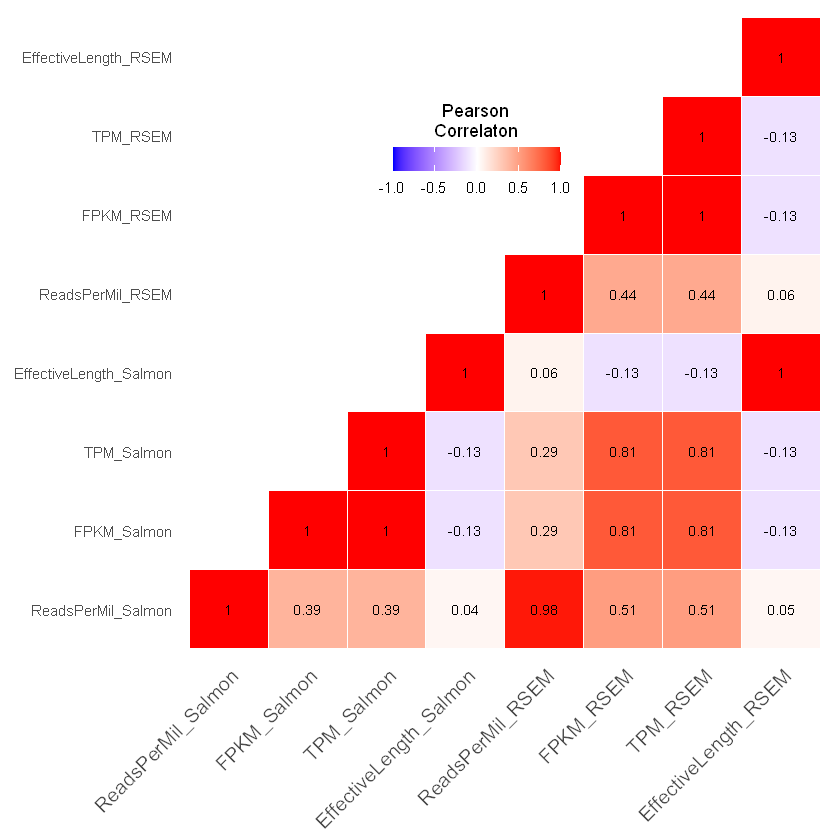

In [9]:
# 绘制heatmap

ggheatmap <- ggplot(cormat, aes(Var2, Var1, fill=value)) +
  geom_tile(color = "white")+  # 绘制热图单元格
  scale_fill_gradient2(
    low = "blue", high = "red", mid = "white",
    midpoint = 0, limit = c(-1, 1), space = "Lab",
    name = "Pearson\nCorrelaton"
  ) +  # 定义颜色渐变（从负相关的蓝色到正相关的红色）
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1,
                                   size = 12, hjust = 1)) +
  coord_fixed() +
  geom_text(
    aes(Var2, Var1, label = round(value, 2)),
    color = "black",
    size = 3
  ) +  # 在热图中添加相关系数的数值标签。
  theme(
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    panel.grid.major = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank(),
    axis.ticks = element_blank(),
    legend.justification = c(1, 0),
    legend.position = c(0.6, 0.7),
    legend.direction = "horizontal"
  ) +
  guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                               title.position = "top", title.hjust = 0.5))

print(ggheatmap)

**从以上热图可知：**
1. RSEM和Salmon的`Effective Length`完全相关；
2. 但是`Effective Length`与两种方法的其余3个指标几乎都不相关。
3. RSEM和Salmon的`ReadsPermil`（normalized read count）基本完全相关；
4. 而`ReadsPermil`与两种方法的TPM、FPKM相关性都不高。
5. RSEM和Salmon的TPM、FPKM这四个指标两两之间高度相关（Pearson相关系数均为0.81）.

**此外：**
1. RSEM自身的`FPKM`和`TPM`完全相关；
2. Salmon自身的`FPKM`和`TPM`完全相关；

并且，几乎所有的相关系数都为正。

## 3 不同指标之间的散点图

例举不同指标之间的散点图，观察各指标之间的相关性和定量差异。

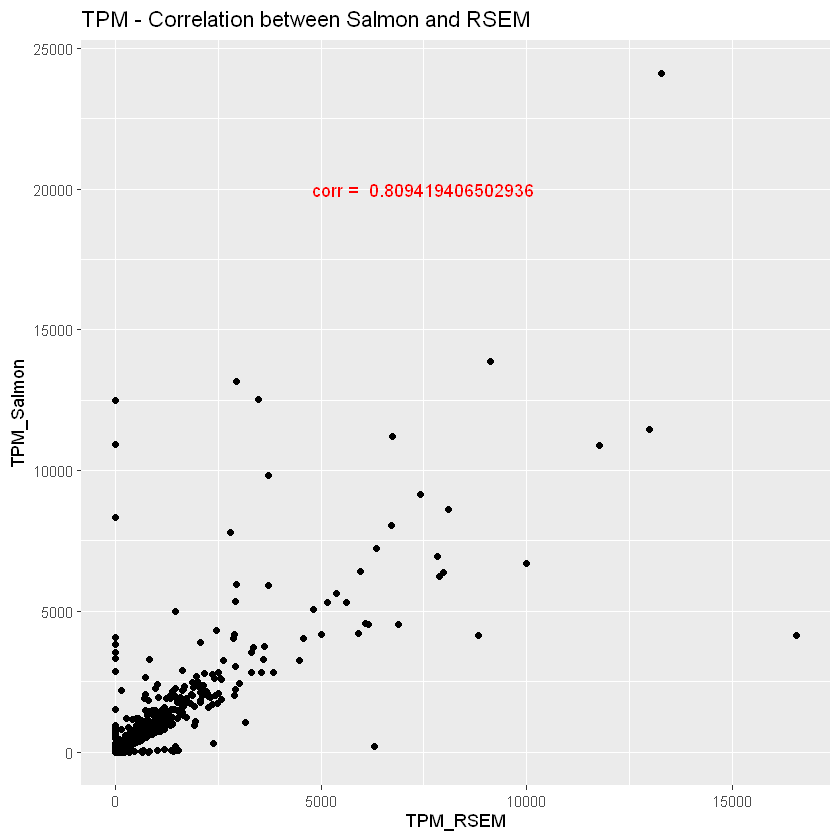

In [10]:
corr1 <- cormat[which(cormat$Var2 == "TPM_RSEM" & cormat$Var1 == "TPM_Salmon"),
                "value"]

dat %>%
  ggplot(aes(x = TPM_RSEM, y = TPM_Salmon)) + 
  geom_point() +
  annotate(geom = "text", x = 7500, y = 20000,
           label = paste("corr = ", corr1), color = "red")+
  ggtitle("TPM - Correlation between Salmon and RSEM")

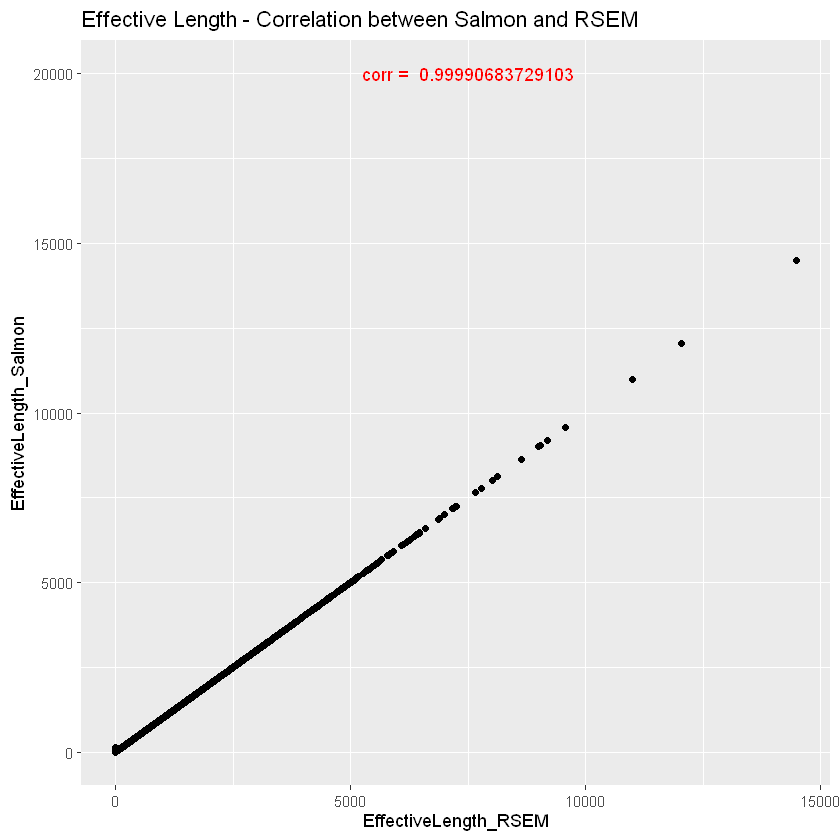

In [11]:
corr2 <- cormat[which(cormat$Var2 == "EffectiveLength_RSEM" &
                        cormat$Var1 == "EffectiveLength_Salmon"),
                "value"]

dat %>%
  ggplot(aes(x = EffectiveLength_RSEM, y = EffectiveLength_Salmon)) +
  geom_point() +
  annotate(geom = "text", x = 7500, y = 20000,
           label = paste("corr = ", corr2), color = "red") +
  ggtitle("Effective Length - Correlation between Salmon and RSEM")

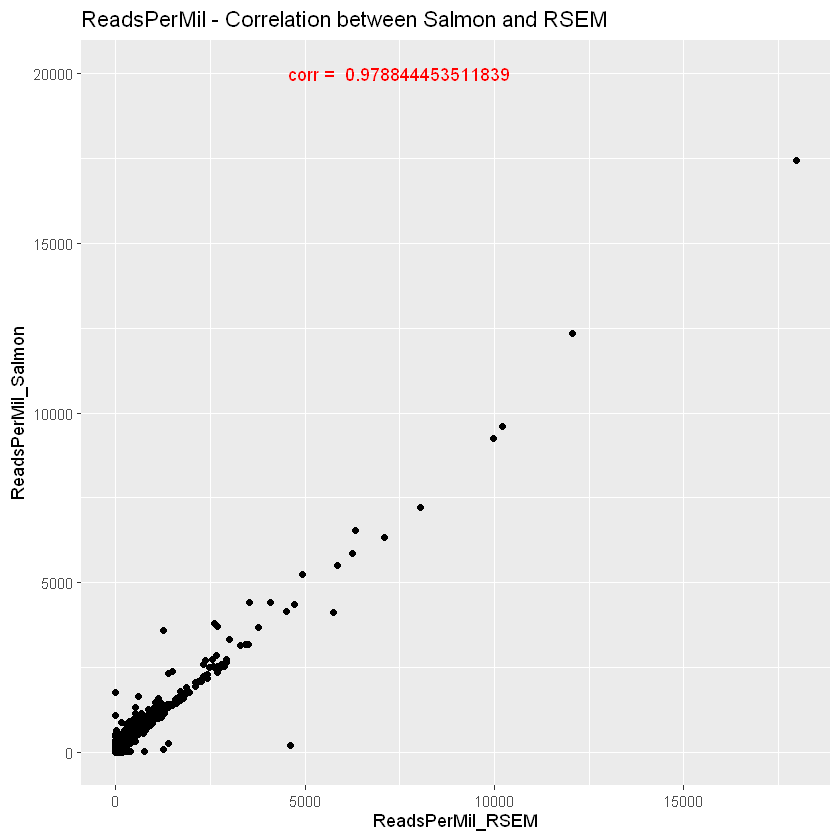

In [12]:
corr3 <- cormat[which(cormat$Var2 == "ReadsPerMil_RSEM" &
                        cormat$Var1 == "ReadsPerMil_Salmon"),
                "value"]

dat %>%
  ggplot(aes(x = ReadsPerMil_RSEM, y = ReadsPerMil_Salmon)) +
  geom_point() +
  annotate(geom = "text", x = 7500, y = 20000,
           label = paste("corr = ", corr3), color = "red") +
  ggtitle("ReadsPerMil - Correlation between Salmon and RSEM")